In [12]:
import numpy as np

In [13]:
from tensorflow.keras import optimizers

In [14]:
import pandas as pd, pickle, re
from konlpy.tag import Okt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow as tf
from sklearn.model_selection import train_test_split

In [15]:
from tensorflow.keras.callbacks import EarlyStopping

In [16]:
import matplotlib.pyplot as plt

In [17]:
tf.__version__

'1.14.0'

In [18]:
from tensorflow.keras.preprocessing.text import Tokenizer

with open('./input_data.pickle', 'rb') as handle:
    data = pickle.load(handle)

embedding_size, max_features,keras_tokenizer, _input, _label = data

word_index = keras_tokenizer.word_index
index_word = keras_tokenizer.index_word

print(max_features)
print(keras_tokenizer)
print(_input)
print(_label[:20])


17815
[[  998     4   132 ...     0     0     0]
 [   27   158     2 ...     0     0     0]
 [   21     6    88 ...     0     0     0]
 ...
 [  353    18   254 ...     0     0     0]
 [  252    19 11090 ...     0     0     0]
 [   83     2   677 ...     0     0     0]]
0     1
1     1
2     1
3     1
4     1
5     1
6     1
7     1
8     1
9     1
10    1
11    1
12    1
13    1
14    1
15    1
16    1
17    1
18    1
19    1
Name: label, dtype: int64


In [19]:
embedding_size=128

In [20]:
input_train,input_test,label_train, label_test = train_test_split(_input,_label, test_size=0.1,stratify =_label)

print('input_train:',input_train[:2])
print('input_test:',input_test[:2])
print('label_train:',[label_train[:2]])
print('label_test:',[label_test[:2]])

input_train: [[   81    21  2388     4   152   416   518     3  1134   987     7   194
     26   236  4640     8  3374    15    46   156  5005 10207    66   907
    475   441   194    26  1785   480   194  1065     2   486     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0]
 [  640   491   888  2730  1838  1377     3 17148    28    25     4   894
     35   174  4334    24    11    97   493    15   234 16343    14     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     

BUFFER_SIZE = len(input_train)
steps_per_epoch = len(input_train) // BATCH_SIZE
SIZE_INPUT = len(lan_input.word_index) + 1
SIZE_TARGET = len(lan_target.word_index) + 1

dataset = tf.data.Dataset.from_tensor_slices((input_train, label_train)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)


In [ ]:
#인코더를 정의하는 클래스 입니다.
class Encoder(tf.keras.Model):
    def __init__(self, vocab_size, EMD_DM, enc_units, batch_sz):
        super(Encoder, self).__init__()
        self.batch_sz = batch_sz
        self.enc_units = enc_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, EMD_DM)
        # TODO: GRU 신경망을 Keras를 이용하여 설정한 인코더 유닛만큼 self.gru에 선언합니다.(return_sequences=True, return_state=True)
        self.gru = tf.keras.layers.GRU(self.enc_units, return_sequences=True, return_state=True, 
                                       recurrent_initializer='glorot_uniform')

    def call(self, x, hidden):
        x = self.embedding(x)
        # TODO: GRU의 입력을 x로, 초기 상태를 hidden으로 설정합니다. 
        output, state = self.gru(x)
        return output, state

    def initialize_hidden_state(self):
        return tf.zeros((self.batch_sz, self.enc_units))

#어텐션을 정의하는 클래스 입니다.
class Attention(tf.keras.Model):
    def __init__(self, UNITS):
        super(Attention, self).__init__()
        self.W1 = tf.keras.layers.Dense(UNITS)
        self.W2 = tf.keras.layers.Dense(UNITS)
        self.V = tf.keras.layers.Dense(1)

    def call(self, query, values):       
        _hidden = tf.expand_dims(query, 1)
        # TODO: values를 W1에 _hidden을 W2에 연산을 적용한 후, 이를 V에 적용합니다. 
        score = self.V(tf.nn.tanh(self.W1( values) + self.W2(_hidden)))
        attention_weights = tf.nn.softmax(score, axis=1)
        context_vector = attention_weights * values
        context_vector = tf.reduce_sum(context_vector, axis=1)

        return context_vector, attention_weights

# 디코더를 정의하는 클래스 입니다.
class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, EMD_DM, dec_units, batch_sz):
        super(Decoder, self).__init__()
        self.batch_sz = batch_sz
        self.dec_units = dec_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, EMD_DM)
        self.gru = tf.keras.layers.GRU(self.dec_units, return_sequences=True, return_state=True, 
                                       recurrent_initializer='glorot_uniform')
        self.fc = tf.keras.layers.Dense(vocab_size)
        self.attention = Attention(self.dec_units)

    def call(self, _x, hidden, out_encoder):
        context_vector, attention_weights = self.attention(hidden, out_encoder)
        _x = self.embedding(_x)
        _x = tf.concat([tf.expand_dims(context_vector, 1), _x], axis=-1)
        output, state = self.gru(_x)
        output = tf.reshape(output, (-1, output.shape[2]))
        x = self.fc(output)

        return x, state, attention_weights

#손실함수를 정의하는 함수입니다.
def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)


def train_step(input_, target_, hidden_encoder):
    loss = 0

    with tf.GradientTape() as tape:
        output_encoder, hidden_encoder = encoder(input_, hidden_encoder)
        hidden_decoder = hidden_encoder
        input_decoder = tf.expand_dims([lan_target.word_index['<start>']] * BATCH_SIZE, 1)
        for t in range(1, target_.shape[1]):
            predictions, hidden_decoder, _ = decoder(input_decoder, hidden_decoder, output_encoder)
            loss += loss_function(target_[:, t], predictions)
            dec_input = tf.expand_dims(target_[:, t], 1)

    loss_batch = (loss / int(target_.shape[1]))
    trainable_variables = encoder.trainable_variables + decoder.trainable_variables
    gradients = tape.gradient(loss, trainable_variables)
    optimizer.apply_gradients(zip(gradients, trainable_variables))

    return loss_batch


encoder = Encoder(SIZE_INPUT, EMD_DM, UNITS, BATCH_SIZE)
decoder = Decoder(SIZE_TARGET, EMD_DM, UNITS, BATCH_SIZE)
optimizer = tf.keras.optimizers.Adam()

# 학습을 진행합니다.
for epoch in range(EPOCHS):
    hidden_encoder = encoder.initialize_hidden_state()
    total_loss = 0
    for (batch, (input_data, target_data)) in enumerate(dataset.take(steps_per_epoch)):

        batch_loss = train_step(input_data, target_data, hidden_encoder)
        total_loss += batch_loss
        if batch % 100 == 0:
            print('Epoch {} Batch {} Loss {:.4f}'.format(epoch+1, batch, batch_loss.numpy()))
    print("[EPOCH - {}] Total Loss: {}".format(epoch+1, total_loss/steps_per_epoch))

In [21]:
def expand_dim(_input):
    return tf.expand_dims(_input, -1)

def print_fn(_input):
    print(_input.shape)
    return _input

def conv(_input):
    out1 = tf.keras.layers.Conv1D(16, kernel_size=1, padding='same', strides=1)(_input)
    out2 = tf.keras.layers.Conv1D(16, kernel_size=2, padding='same', strides=1)(_input)
    out3 = tf.keras.layers.Conv1D(16, kernel_size=3, padding='same', strides=1)(_input)
    concat = tf.keras.layers.concatenate([out1, out2, out3])
    return concat

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(max_features,embedding_size),
    tf.keras.layers.Lambda(conv),
    tf.keras.layers.Lambda(conv),
    tf.keras.layers.GlobalMaxPool1D(),
    tf.keras.layers.Dense(256, activation = tf.nn.relu),
    tf.keras.layers.Dropout(0.05),
    tf.keras.layers.Dense(1, activation = tf.nn.softmax),
    ])


# 모델 하나 만들어보기

### LSTM

In [40]:
# LSTM 1
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(max_features, 32),
    tf.keras.layers.LSTM(32,activation=tf.nn.tanh),
    tf.keras.layers.Lambda(expand_dim),
    tf.keras.layers.GlobalMaxPool1D(),
    tf.keras.layers.Dense(1, activation = tf.nn.sigmoid),
    ])

model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics=['acc'])

early_stopping = EarlyStopping(monitor='val_acc', min_delta=0, patience=0, verbose=2, mode='auto')

hist = model.fit(input_train, label_train, batch_size=500, epochs=20, validation_data=(input_test, label_test),
                callbacks=[early_stopping])

loss, score = model.evaluate(input_test, label_test)
s1=score
print('model accuracy:{}'.format(score))

Train on 14185 samples, validate on 1577 samples
Epoch 1/20
14185/14185 [==============================] - 15s 1ms/sample - loss: 0.6933 - acc: 0.5000 - val_loss: 0.6932 - val_acc: 0.4997
Epoch 2/20
14185/14185 [==============================] - 13s 890us/sample - loss: 0.6933 - acc: 0.5000 - val_loss: 0.6932 - val_acc: 0.4997
Epoch 00002: early stopping
1577/1577 [==============================] - 1s 333us/sample - loss: 0.6932 - acc: 0.4997
model accuracy:0.4996829330921173


In [23]:
# LSTM + conv
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(max_features, embedding_size),
    tf.keras.layers.LSTM(8,activation=tf.nn.tanh),
    tf.keras.layers.Lambda(expand_dim),
    tf.keras.layers.Lambda(conv),
    tf.keras.layers.GlobalMaxPool1D(),
    tf.keras.layers.Dense(1, activation = tf.nn.sigmoid),
    ])

model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics=['acc'])

early_stopping = EarlyStopping(monitor='val_acc', min_delta=0, patience=0, verbose=2, mode='auto')

hist = model.fit(input_train, label_train, batch_size=500, epochs=20, validation_data=(input_test, label_test),
                callbacks=[early_stopping])

loss, score = model.evaluate(input_test, label_test)
s2=score
print('model accuracy:{}'.format(score))

Train on 14185 samples, validate on 1577 samples
Epoch 1/20
14185/14185 [==============================] - 6s 443us/sample - loss: 0.6932 - acc: 0.5013 - val_loss: 0.6932 - val_acc: 0.5003
Epoch 2/20
14185/14185 [==============================] - 6s 393us/sample - loss: 0.6932 - acc: 0.5030 - val_loss: 0.6932 - val_acc: 0.4997
Epoch 00002: early stopping
1577/1577 [==============================] - 1s 441us/sample - loss: 0.6932 - acc: 0.4997
model accuracy:0.4996829330921173


### GRU

In [24]:
# GRU 1
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(max_features, embedding_size),
    tf.keras.layers.GRU(8, activation = tf.nn.tanh),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1, activation = tf.nn.sigmoid),
    ])

model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics=['acc'])

early_stopping = EarlyStopping(monitor='val_acc', min_delta=0, patience=0, verbose=2, mode='auto')

hist = model.fit(input_train, label_train, batch_size=500, epochs=20, validation_data=(input_test, label_test),
                callbacks=[early_stopping])

loss, score = model.evaluate(input_test, label_test)
s3=score

print('model accuracy:{}'.format(score))

Train on 14185 samples, validate on 1577 samples
Epoch 1/20
14185/14185 [==============================] - 5s 361us/sample - loss: 0.6933 - acc: 0.5042 - val_loss: 0.6936 - val_acc: 0.4997
Epoch 2/20
14185/14185 [==============================] - 4s 313us/sample - loss: 0.6933 - acc: 0.5007 - val_loss: 0.6932 - val_acc: 0.5003
Epoch 3/20
14185/14185 [==============================] - 4s 304us/sample - loss: 0.6932 - acc: 0.5026 - val_loss: 0.6933 - val_acc: 0.4997
Epoch 00003: early stopping
1577/1577 [==============================] - 1s 346us/sample - loss: 0.6933 - acc: 0.4997
model accuracy:0.4996829330921173


In [25]:
# GRU +conv
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(max_features, embedding_size),
    tf.keras.layers.GRU(8, activation = tf.nn.tanh),
    tf.keras.layers.Lambda(expand_dim),
    tf.keras.layers.Lambda(conv),
    tf.keras.layers.GlobalMaxPool1D(),
    tf.keras.layers.Dense(1, activation = tf.nn.sigmoid),
    ])

model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics=['acc'])

early_stopping = EarlyStopping(monitor='val_acc', min_delta=0, patience=0, verbose=2, mode='auto')

hist = model.fit(input_train, label_train, batch_size=500, epochs=20, validation_data=(input_test, label_test),
                callbacks=[early_stopping])

loss, score = model.evaluate(input_test, label_test)
s4=score

print('model accuracy:{}'.format(score))

Train on 14185 samples, validate on 1577 samples
Epoch 1/20
14185/14185 [==============================] - 5s 379us/sample - loss: 0.6932 - acc: 0.5010 - val_loss: 0.6932 - val_acc: 0.5003
Epoch 2/20
14185/14185 [==============================] - 5s 339us/sample - loss: 0.6932 - acc: 0.4901 - val_loss: 0.6931 - val_acc: 0.5003
Epoch 00002: early stopping
1577/1577 [==============================] - 1s 401us/sample - loss: 0.6931 - acc: 0.5003
model accuracy:0.5003170371055603


### BiRNN(Bidirectional RNN)

In [44]:
# Bidirectional RNN 1층 (LSTM)
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(max_features, embedding_size),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(8,activation = tf.nn.relu,return_sequences = True)),
    tf.keras.layers.GlobalMaxPooling1D(),
    tf.keras.layers.Dense(1, activation = tf.nn.sigmoid),
    ])

model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics=['acc'])

early_stopping = EarlyStopping(monitor='val_acc', min_delta=0, patience=0, verbose=2, mode='auto')

hist = model.fit(input_train, label_train, batch_size=500, epochs=20, validation_data=(input_test, label_test),
                callbacks=[early_stopping])

loss, score = model.evaluate(input_test, label_test)
s5=score
print('model accuracy:{}'.format(score))

Train on 14185 samples, validate on 1577 samples
Epoch 1/20
14185/14185 [==============================] - 25s 2ms/sample - loss: 0.6782 - acc: 0.7552 - val_loss: 0.6500 - val_acc: 0.8859
Epoch 2/20
14185/14185 [==============================] - 20s 1ms/sample - loss: 0.5815 - acc: 0.9069 - val_loss: 0.4748 - val_acc: 0.8998
Epoch 3/20
14185/14185 [==============================] - 20s 1ms/sample - loss: 1.1060 - acc: 0.9146 - val_loss: 0.7755 - val_acc: 0.9093
Epoch 4/20
14185/14185 [==============================] - 20s 1ms/sample - loss: 0.2694 - acc: 0.9367 - val_loss: 0.4032 - val_acc: 0.9144
Epoch 5/20
14185/14185 [==============================] - 20s 1ms/sample - loss: 0.2058 - acc: 0.9480 - val_loss: 0.7073 - val_acc: 0.9157
Epoch 6/20
14185/14185 [==============================] - 20s 1ms/sample - loss: 0.1590 - acc: 0.9584 - val_loss: 0.9923 - val_acc: 0.9093
Epoch 00006: early stopping
1577/1577 [==============================] - 1s 625us/sample - loss: 0.9923 - acc: 0.9093

In [27]:
# Bidirectional RNN 2층 (LSTM)

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(max_features, embedding_size),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(8,activation = tf.nn.relu,return_sequences = True)),
    tf.keras.layers.GlobalMaxPooling1D(),
    tf.keras.layers.Dense(20, activation=tf.nn.relu),
    #tf.keras.layers.Dropout(0.05),
    tf.keras.layers.Dense(1, activation = tf.nn.sigmoid),
    ])

model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics=['acc'])

early_stopping = EarlyStopping(monitor='val_acc', min_delta=0, patience=0, verbose=2, mode='auto')

hist = model.fit(input_train, label_train, batch_size=500, epochs=20, validation_data=(input_test, label_test),
                callbacks=[early_stopping])

loss, score = model.evaluate(input_test, label_test)

print('model accuracy:{}'.format(score))

Train on 14185 samples, validate on 1577 samples
Epoch 1/20
14185/14185 [==============================] - 14s 1ms/sample - loss: 0.6833 - acc: 0.7281 - val_loss: 0.6603 - val_acc: 0.8789
Epoch 2/20
14185/14185 [==============================] - 13s 893us/sample - loss: 0.5901 - acc: 0.8983 - val_loss: 0.4647 - val_acc: 0.8916
Epoch 3/20
14185/14185 [==============================] - 12s 834us/sample - loss: 656500.5956 - acc: 0.9086 - val_loss: 0.2565 - val_acc: 0.9106
Epoch 4/20
14185/14185 [==============================] - 12s 864us/sample - loss: 0.1905 - acc: 0.9449 - val_loss: 1.2486 - val_acc: 0.9125
Epoch 5/20
14185/14185 [==============================] - 12s 855us/sample - loss: 0.2362 - acc: 0.9573 - val_loss: 0.2035 - val_acc: 0.9131
Epoch 6/20
14185/14185 [==============================] - 12s 859us/sample - loss: 0.1108 - acc: 0.9688 - val_loss: 0.1995 - val_acc: 0.9106
Epoch 00006: early stopping
1577/1577 [==============================] - 1s 726us/sample - loss: 0.199

In [28]:
# Bidirectional RNN dropout (LSTM)

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(max_features, embedding_size),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(8, activation = tf.nn.relu,return_sequences = True)),
    tf.keras.layers.GlobalMaxPooling1D(),
    tf.keras.layers.Dense(20, activation=tf.nn.relu),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(1, activation = tf.nn.sigmoid),
    ])

model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics=['acc'])

early_stopping = EarlyStopping(monitor='val_acc', min_delta=0, patience=0, verbose=2, mode='auto')

hist = model.fit(input_train, label_train, batch_size=500, epochs=20, validation_data=(input_test, label_test),
                callbacks=[early_stopping])

loss, score = model.evaluate(input_test, label_test)

print('model accuracy:{}'.format(score))

Train on 14185 samples, validate on 1577 samples
Epoch 1/20
14185/14185 [==============================] - 14s 1ms/sample - loss: 0.6842 - acc: 0.6277 - val_loss: 0.6644 - val_acc: 0.8294
Epoch 2/20
14185/14185 [==============================] - 12s 876us/sample - loss: 23.8609 - acc: 0.8045 - val_loss: 0.4972 - val_acc: 0.8789
Epoch 3/20
14185/14185 [==============================] - 12s 850us/sample - loss: 894.1586 - acc: 0.8546 - val_loss: 0.3730 - val_acc: 0.8897
Epoch 4/20
14185/14185 [==============================] - 12s 863us/sample - loss: 1758657.7560 - acc: 0.9162 - val_loss: 52.3837 - val_acc: 0.9042
Epoch 5/20
14185/14185 [==============================] - 13s 890us/sample - loss: 3320.6312 - acc: 0.9387 - val_loss: 40.1386 - val_acc: 0.9030
Epoch 00005: early stopping
1577/1577 [==============================] - 1s 589us/sample - loss: 40.1386 - acc: 0.9030
model accuracy:0.9029803276062012


In [29]:
# Bidirectional RNN (GRU)

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(max_features, embedding_size),
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(8,activation = tf.nn.relu, return_sequences = True)),
    tf.keras.layers.GlobalMaxPooling1D(),
    tf.keras.layers.Dense(1, activation = tf.nn.sigmoid),
    ])

model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics=['acc'])

early_stopping = EarlyStopping(monitor='val_acc', min_delta=0, patience=0, verbose=2, mode='auto')

hist = model.fit(input_train, label_train, batch_size=500, epochs=20, validation_data=(input_test, label_test),
                callbacks=[early_stopping])

loss, score = model.evaluate(input_test, label_test)
s6=score
print('model accuracy:{}'.format(score))

Train on 14185 samples, validate on 1577 samples
Epoch 1/20
14185/14185 [==============================] - 15s 1ms/sample - loss: 0.6725 - acc: 0.7122 - val_loss: 0.6392 - val_acc: 0.8706
Epoch 2/20
14185/14185 [==============================] - 12s 839us/sample - loss: 0.5725 - acc: 0.9101 - val_loss: 0.4982 - val_acc: 0.9042
Epoch 3/20
14185/14185 [==============================] - 11s 786us/sample - loss: 0.3753 - acc: 0.9313 - val_loss: 0.3000 - val_acc: 0.9131
Epoch 4/20
14185/14185 [==============================] - 12s 813us/sample - loss: 0.2101 - acc: 0.9416 - val_loss: 0.2099 - val_acc: 0.9201
Epoch 5/20
14185/14185 [==============================] - 11s 767us/sample - loss: 0.1361 - acc: 0.9569 - val_loss: 0.1932 - val_acc: 0.9188
Epoch 00005: early stopping
1577/1577 [==============================] - 1s 620us/sample - loss: 0.1932 - acc: 0.9188
model accuracy:0.9188332557678223


### CNN을 활용한 문서분석

In [30]:
# CNN + BiRNN(Bidirectional RNN), LSTM

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(max_features, embedding_size),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(8,activation = tf.nn.relu,return_sequences = True)),
    tf.keras.layers.GlobalMaxPool1D(),
    tf.keras.layers.Lambda(expand_dim),
    tf.keras.layers.Lambda(conv),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1, activation = tf.nn.sigmoid),
    ])

model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics=['acc'])

early_stopping = EarlyStopping(monitor='val_acc', min_delta=0, patience=0, verbose=2, mode='auto')

hist = model.fit(input_train, label_train, batch_size=500, epochs=20, validation_data=(input_test, label_test),
                callbacks=[early_stopping])

loss, score = model.evaluate(input_test, label_test)
s7=score
print('model accuracy:{}'.format(score))

Train on 14185 samples, validate on 1577 samples
Epoch 1/20
14185/14185 [==============================] - 15s 1ms/sample - loss: 0.6784 - acc: 0.7186 - val_loss: 0.6326 - val_acc: 0.8814
Epoch 2/20
14185/14185 [==============================] - 13s 921us/sample - loss: 0.4773 - acc: 0.9131 - val_loss: 0.2923 - val_acc: 0.9062
Epoch 3/20
14185/14185 [==============================] - 13s 897us/sample - loss: 0.1886 - acc: 0.9376 - val_loss: 0.2005 - val_acc: 0.9150
Epoch 4/20
14185/14185 [==============================] - 13s 914us/sample - loss: 0.1024 - acc: 0.9648 - val_loss: 0.2017 - val_acc: 0.9144
Epoch 00004: early stopping
1577/1577 [==============================] - 1s 770us/sample - loss: 0.2017 - acc: 0.9144
model accuracy:0.9143944382667542


In [31]:
# CNN + BiRNN(Bidirectional RNN), GRU

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(max_features, 31),
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(8,activation = tf.nn.relu,return_sequences = True, dropout=0.5)),
    tf.keras.layers.GlobalMaxPool1D(),
    tf.keras.layers.Lambda(expand_dim),
    tf.keras.layers.Lambda(conv),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1, activation = tf.nn.sigmoid),
    ])

model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics=['acc'])

early_stopping = EarlyStopping(monitor='val_acc', min_delta=0, patience=0, verbose=2, mode='auto')

hist = model.fit(input_train, label_train, batch_size=500, epochs=20, validation_data=(input_test, label_test),
                callbacks=[early_stopping])

loss, score = model.evaluate(input_test, label_test)
s8=score
print('model accuracy:{}'.format(score))

Train on 14185 samples, validate on 1577 samples
Epoch 1/20
14185/14185 [==============================] - 8s 538us/sample - loss: 0.6906 - acc: 0.5996 - val_loss: 0.6795 - val_acc: 0.7990
Epoch 2/20
14185/14185 [==============================] - 5s 375us/sample - loss: 0.6338 - acc: 0.8378 - val_loss: 0.5314 - val_acc: 0.8884
Epoch 3/20
14185/14185 [==============================] - 5s 346us/sample - loss: 0.3922 - acc: 0.9058 - val_loss: 0.2657 - val_acc: 0.9100
Epoch 4/20
14185/14185 [==============================] - 5s 341us/sample - loss: 0.2069 - acc: 0.9298 - val_loss: 0.1992 - val_acc: 0.9214
Epoch 5/20
14185/14185 [==============================] - 5s 338us/sample - loss: 0.1411 - acc: 0.9493 - val_loss: 0.1957 - val_acc: 0.9214
Epoch 00005: early stopping
1577/1577 [==============================] - 1s 680us/sample - loss: 0.1957 - acc: 0.9214
model accuracy:0.9213696718215942


adam = optimizers.Adam(lr = 0.001)

s1=0.801787
s2=0.803981
s3=0.801381
s4=0.805037
s5=0.80528
s6=0.809748
s7=0.807799
s8=0.804387

In [32]:
df_model=pd.DataFrame([[s1,s2,s3,s4,s5,s6,s7,s8]],columns=['LSTM','LSTM+CNN','GRU','GRU+CNN','BiRNN(LSTM)',
                                                         'BiRNN(GRU)','CNN+BiRNN(LSTM)','CNN+BiRNN(GRU)'])
df_model

,LSTM,LSTM+CNN,GRU,GRU+CNN,BiRNN(LSTM),BiRNN(GRU),CNN+BiRNN(LSTM),CNN+BiRNN(GRU)
0,0.500317,0.499683,0.499683,0.500317,0.906785,0.918833,0.914394,0.92137


In [33]:
df_=df_model.T.sort_values(0)
df_

,0
LSTM+CNN,0.499683
GRU,0.499683
LSTM,0.500317
GRU+CNN,0.500317
BiRNN(LSTM),0.906785
CNN+BiRNN(LSTM),0.914394
BiRNN(GRU),0.918833
CNN+BiRNN(GRU),0.921370


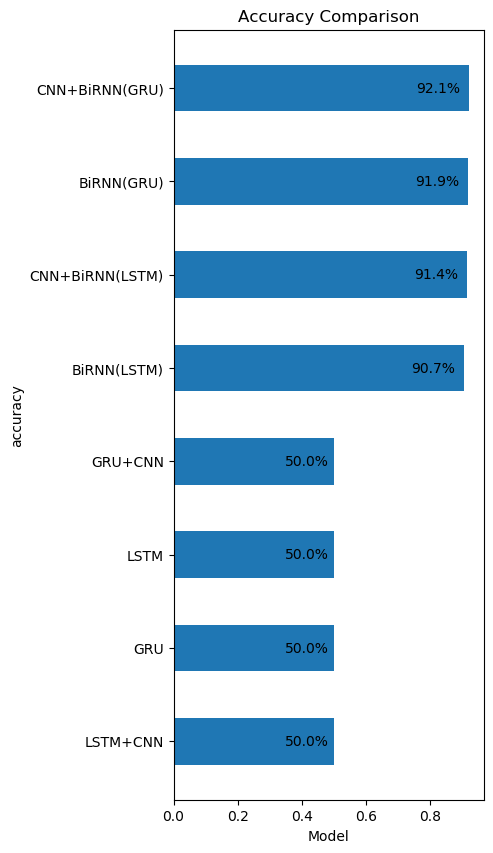

In [35]:
import matplotlib
import matplotlib.pylab as plt
%matplotlib inline
from matplotlib import style

style.use('default')

ypos = np.arange(8)
fig = plt.figure(figsize=(4, 10))
ax = fig.add_subplot(111)


rects = plt.barh(ypos, df_[0], align='center', height=0.5)

for i, rect in enumerate(rects):
    ax.text(0.97 * rect.get_width(), rect.get_y() + rect.get_height() / 2.0, str(np.round(df_[0][i]*100,1)) + '%', ha='right', va='center')



plt.title("Accuracy Comparison")
#matplotlib.rc(['xtick','ytick'], labelsize=12) 

plt.yticks(ypos, df_.index)
#plt.xlim(0.65, 0.85)
plt.xlabel("Model")
plt.ylabel("accuracy")
plt.show()

In [ ]:
# 5. 모델 학습 과정 표시하기
%matplotlib inline
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots()

acc_ax = loss_ax.twinx()

loss_ax.plot(hist.history['loss'], 'y', label='train loss')
loss_ax.plot(hist.history['val_loss'], 'r', label='val loss')

acc_ax.plot(hist.history['acc'], 'b', label='train acc')
acc_ax.plot(hist.history['val_acc'], 'g', label='val acc')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuray')

loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')

plt.show()

saver = tf.train.Saver()
sess = tf.Session()
sess.run(tf.global_variables_initializer())
saver.save(sess, 'my_test_model')

In [15]:
import numpy
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.optimizers import Adam

In [11]:
from tensorflow.keras.optimizers import Adadelta

In [12]:
from tensorflow.keras.layers import Dropout
#from tensorflow.keras.constraints import maxnorm

# Use scikit-learn to grid search the batch size and epochs

In [30]:
# Function to create model, required for KerasClassifier
def create_model():
    # create model
    model = Sequential()
    model.add(tf.keras.layers.Embedding(max_features, embedding_size))
    model.add(tf.keras.layers.GRU(8, activation = tf.nn.tanh))
    model.add(tf.keras.layers.Flatten())
    model.add(Dense(1, activation='sigmoid'))
    # Compile model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

# create model
model = KerasClassifier(build_fn=create_model, epochs=10, verbose=0)

# define the grid search parameters
batch_size = [100, 200, 300, 400, 500, 600]
param_grid = dict(batch_size=batch_size)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1)

early_stopping = EarlyStopping(monitor='val_acc', min_delta=0, patience=0, verbose=2, mode='auto')
grid_result = grid.fit(input_train, label_train, validation_data=(input_test, label_test), callbacks=[early_stopping])

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

C:\Users\USER\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\USER\Anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


Epoch 00005: early stopping
Best: 0.794108 using {'batch_size': 500}
0.793041 (0.003794) with: {'batch_size': 100}
0.793365 (0.002985) with: {'batch_size': 200}
0.792645 (0.000485) with: {'batch_size': 300}
0.792513 (0.003537) with: {'batch_size': 400}
0.794108 (0.001914) with: {'batch_size': 500}
0.595722 (0.136622) with: {'batch_size': 600}


# Use scikit-learn to grid search the dropout rate

In [13]:
# Function to create model, required for KerasClassifier
def create_model(dropout_rate=0.0):
    # create model
    model = Sequential()
    model.add(tf.keras.layers.Embedding(max_features, embedding_size))
    model.add(tf.keras.layers.GRU(8, activation = tf.nn.tanh, dropout=dropout_rate))
    model.add(tf.keras.layers.Flatten())
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

# create model
model = KerasClassifier(build_fn=create_model, epochs=10, batch_size=500, verbose=0)
# define the grid search parameters

dropout_rate = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6]
param_grid = dict(dropout_rate=dropout_rate)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1)

early_stopping = EarlyStopping(monitor='val_acc', min_delta=0, patience=0, verbose=2, mode='auto')
grid_result = grid.fit(input_train, label_train, validation_data=(input_test, label_test), callbacks=[early_stopping])

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

C:\Users\USER\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\USER\Anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch 00005: early stopping
Best: 0.788569 using {'dropout_rate': 0.0}
0.788569 (0.003231) with: {'dropout_rate': 0.0}
0.692433 (0.137787) with: {'dropout_rate': 0.1}
0.697325 (0.140192) with: {'dropout_rate': 0.2}
0.597197 (0.140306) with: {'dropout_rate': 0.3}
0.500102 (0.001836) with: {'dropout_rate': 0.4}
0.698920 (0.140109) with: {'dropout_rate': 0.5}
0.597928 (0.139466) with: {'dropout_rate': 0.6}
0.499478 (0.001716) with: {'dropout_rate': 0.7}
0.498555 (0.000461) with: {'dropout_rate': 0.8}
0.499442 (0.001693) with: {'dropout_rate': 0.9}


# Use scikit-learn to grid search the weight initialization

In [13]:
# Function to create model, required for KerasClassifier
def create_model(init_mode='uniform'):
    # create model
    model = Sequential()
    model.add(tf.keras.layers.Embedding(max_features, embedding_size))
    model.add(tf.keras.layers.GRU(8, activation = tf.nn.tanh, recurrent_initializer=init_mode))
    model.add(tf.keras.layers.Flatten())
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

# create model
model = KerasClassifier(build_fn=create_model, epochs=10, batch_size=500, verbose=0)
# define the grid search parameters

init_mode = ['uniform', 'lecun_uniform', 'normal', 'zero', 'glorot_normal', 'glorot_uniform', 'he_normal', 'he_uniform']
param_grid = dict(dropout_rate=dropout_rate)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1)

early_stopping = EarlyStopping(monitor='val_acc', min_delta=0, patience=0, verbose=2, mode='auto')
grid_result = grid.fit(input_train, label_train, validation_data=(input_test, label_test), callbacks=[early_stopping])

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

C:\Users\USER\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\USER\Anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch 00005: early stopping
Best: 0.788569 using {'dropout_rate': 0.0}
0.788569 (0.003231) with: {'dropout_rate': 0.0}
0.692433 (0.137787) with: {'dropout_rate': 0.1}
0.697325 (0.140192) with: {'dropout_rate': 0.2}
0.597197 (0.140306) with: {'dropout_rate': 0.3}
0.500102 (0.001836) with: {'dropout_rate': 0.4}
0.698920 (0.140109) with: {'dropout_rate': 0.5}
0.597928 (0.139466) with: {'dropout_rate': 0.6}
0.499478 (0.001716) with: {'dropout_rate': 0.7}
0.498555 (0.000461) with: {'dropout_rate': 0.8}
0.499442 (0.001693) with: {'dropout_rate': 0.9}


# Use scikit-learn to grid search the number of neurons

In [16]:
def create_model(neurons=1):
    # create model
    model = Sequential()
    model.add(tf.keras.layers.Embedding(max_features, embedding_size))
    model.add(tf.keras.layers.GRU(neurons, activation = tf.nn.tanh))
    model.add(tf.keras.layers.Flatten())
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

# create model
model = KerasClassifier(build_fn=create_model, epochs=10, batch_size=500, verbose=0)
# define the grid search parameters
neurons = [1, 8, 16, 32, 64, 128]
param_grid = dict(neurons=neurons)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1)

early_stopping = EarlyStopping(monitor='val_acc', min_delta=0, patience=0, verbose=2, mode='auto')
grid_result = grid.fit(input_train, label_train, validation_data=(input_test, label_test), callbacks=[early_stopping])

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

C:\Users\USER\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\USER\Anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


Epoch 00004: early stopping
Best: 0.790871 using {'neurons': 8}
0.673705 (0.123287) with: {'neurons': 1}
0.790871 (0.003993) with: {'neurons': 8}
0.695826 (0.136361) with: {'neurons': 16}
0.790115 (0.000978) with: {'neurons': 32}
0.790511 (0.003510) with: {'neurons': 64}
0.788041 (0.005483) with: {'neurons': 128}


# 씅의 그리드서치

In [ ]:
# Function to create model, required for KerasClassifier
def create_model(neurons=1, dropout_rate=0.0, activation='relu'):
    # create model
    model = Sequential()
    model.add(tf.keras.layers.Embedding(max_features, embedding_size))
    model.add(tf.keras.layers.Bidirectional(tf.keras.layers.GRU(neurons, activation = activation,
                                                                return_sequences = True, dropout=dropout_rate)))
    model.add(tf.keras.layers.GlobalMaxPool1D())
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

# create model
model = KerasClassifier(build_fn=create_model, epochs=10, batch_size=500, verbose=0)

# define the grid search parameters
neurons = [8, 16, 32, 64]
dropout_rate = [0.0, 0.1, 0.2]

param_grid = dict(neurons=neurons, dropout_rate=dropout_rate, activation=activation)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1)

early_stopping = EarlyStopping(monitor='val_acc', min_delta=0, patience=0, verbose=2, mode='auto')
grid_result = grid.fit(input_train, label_train, validation_data=(input_test, label_test), callbacks=[early_stopping])

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

# 최종모델

In [50]:
# CNN + BiRNN(Bidirectional RNN), GRU

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(max_features, 32),
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(8,activation = tf.nn.relu, return_sequences = True, dropout=0.4)),
    tf.keras.layers.GlobalMaxPool1D(),
    tf.keras.layers.Lambda(expand_dim),
    tf.keras.layers.Lambda(conv),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1, activation = tf.nn.sigmoid),
    ])

model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics=['acc'])

early_stopping = EarlyStopping(monitor='val_acc', min_delta=0, patience=0, verbose=2, mode='auto')

hist = model.fit(input_train, label_train, batch_size=500, epochs=20, validation_data=(input_test, label_test),
                callbacks=[early_stopping])

loss, score = model.evaluate(input_test, label_test)
s8=score
print('model accuracy:{}'.format(score))

Train on 14185 samples, validate on 1577 samples
Epoch 1/20
14185/14185 [==============================] - 13s 937us/sample - loss: 0.6885 - acc: 0.6162 - val_loss: 0.6715 - val_acc: 0.8713
Epoch 2/20
14185/14185 [==============================] - 9s 632us/sample - loss: 0.6079 - acc: 0.8699 - val_loss: 0.4852 - val_acc: 0.8916
Epoch 3/20
14185/14185 [==============================] - 9s 659us/sample - loss: 0.3533 - acc: 0.8883 - val_loss: 0.2530 - val_acc: 0.9106
Epoch 4/20
14185/14185 [==============================] - 10s 681us/sample - loss: 0.1910 - acc: 0.9299 - val_loss: 0.1931 - val_acc: 0.9245
Epoch 5/20
14185/14185 [==============================] - 10s 690us/sample - loss: 0.1291 - acc: 0.9540 - val_loss: 0.1892 - val_acc: 0.9233
Epoch 00005: early stopping
1577/1577 [==============================] - 1s 839us/sample - loss: 0.1892 - acc: 0.9233
model accuracy:0.9232720136642456


In [16]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(max_features, embedding_size),
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(8, activation = 'tanh', return_sequences = True, dropout=0.05)),
    tf.keras.layers.GlobalMaxPool1D(),
    tf.keras.layers.Dense(1, activation = 'sigmoid'),
    ])

model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics=['acc'])

early_stopping = EarlyStopping(monitor='val_acc', min_delta=0, patience=0, verbose=2, mode='auto')

hist = model.fit(input_train, label_train, batch_size=35, epochs=1, validation_data=(input_test, label_test),
                callbacks=[early_stopping])

loss, score = model.evaluate(input_test, label_test)

print('model accuracy:{}'.format(score))

Train on 110782 samples, validate on 12310 samples
12310/12310 [==============================] - 2s 190us/sample - loss: 0.3931 - acc: 0.8223
model accuracy:0.8222583532333374


In [15]:
# CNN + BiRNN(Bidirectional RNN), LSTM

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(max_features, embedding_size),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(8, activation = tf.nn.relu,return_sequences = True)),
    tf.keras.layers.GlobalMaxPool1D(),
    tf.keras.layers.Lambda(expand_dim),
    tf.keras.layers.Lambda(conv),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1, activation = tf.nn.sigmoid),
    ])

model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics=['acc'])

early_stopping = EarlyStopping(monitor='val_acc', min_delta=0, patience=0, verbose=2, mode='auto')

hist = model.fit(input_train, label_train, batch_size=45, epochs=1, validation_data=(input_test, label_test),
                callbacks=[early_stopping])

loss, score = model.evaluate(input_test, label_test)
s7=score
print('model accuracy:{}'.format(score))

Train on 110782 samples, validate on 12310 samples
12310/12310 [==============================] - 2s 190us/sample - loss: 0.3973 - acc: 0.8204
model accuracy:0.8203899264335632


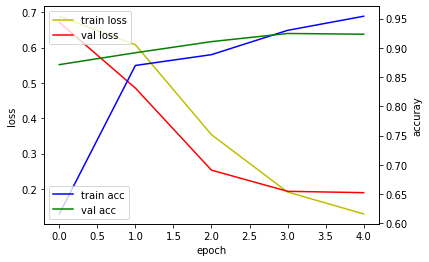

In [51]:
# 5. 모델 학습 과정 표시하기
%matplotlib inline
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots()

acc_ax = loss_ax.twinx()

loss_ax.plot(hist.history['loss'], 'y', label='train loss')
loss_ax.plot(hist.history['val_loss'], 'r', label='val loss')

acc_ax.plot(hist.history['acc'], 'b', label='train acc')
acc_ax.plot(hist.history['val_acc'], 'g', label='val acc')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuray')

loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')

plt.show()

In [52]:
model_json = model.to_json()
with open("model.json", "w") as json_file : 
    json_file.write(model_json)

In [53]:
model.save_weights("model.h5")
print("Saved model to disk")

Saved model to disk


In [115]:
!pip install keras